In [1]:
import pandas as pd
import numpy as np

# 1. Importing data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
merged = pd.concat([train, test], sort=False)

print(f"Train: {train.shape}, Test: {test.shape}")

Train: (891, 12), Test: (418, 11)


# 2. Creating new features, and dealing with missing data  
## Using similar feature engineering as done previously (see previous file)

**`Embarked` and `Fare`**  
Fill missing data with most frequent values, using `mode`.


In [3]:
merged.Embarked.fillna(merged.Embarked.mode().item(), inplace=True)
merged.Fare.fillna(float(merged.Fare.mode()), inplace=True)

**`Name`**  
Extract passenger's Title from their Name, and replace rare titles with either `Mr`, `Mrs` or `Ms`.

In [4]:
merged['Title'] = merged.Name.apply(lambda x: x.split(',')[1].split('.')[0]).str.strip()

In [5]:
merged.Title = np.where(merged.Title.isin(['Major',
                                           'Sir', 
                                           'Don', 
                                           'Jonkheer', 
                                           'Capt',
                                           'Col']), 'Mr', merged.Title)

merged.Title = np.where(merged.Title.isin(['Lady', 
                                           'the Countess', 
                                           'Dona']), 'Mrs', merged.Title)

merged.Title = np.where(merged.Title.isin(['Mlle', 
                                           'Mme', 
                                           'Ms']), 'Miss', merged.Title)

**`Age`**  
Impute missing values depending on median age for a given Title (e.g. `Master` represents young boys)

In [6]:
for title in merged.Title.unique():
    merged.Age = np.where(merged.Age.isnull() & merged.Title.isin([title]), 
                          merged.groupby('Title').Age.median()[title],
                          merged.Age)

**`SibSp` and `Parch`**  
Combine those features into a new one (`Family_size`) and cut it into groups.

In [7]:
merged['Family_size'] = merged.SibSp + merged.Parch + 1
merged.Family_size = pd.cut(merged.Family_size, 
                            [0, 1, 2, 4, np.inf], 
                            labels=['Solo', 'Duo', 'Small Family', 'Large Family']
                           )

**`Ticket` and `Cabin`**  
Replace those features with the Ticket prefix, and the Cabin letter identifier, since they might give valuable information about passenger localization on board.

In [8]:
cabin_letters = merged.Cabin.apply(lambda x: str(x).split()[0][0])
merged.Cabin = np.where(~merged.Cabin.isnull(), cabin_letters, 'U')

In [9]:
merged.Ticket = merged.Ticket.apply(
    lambda x: str(x).split()[0].strip() if not 
    str(x).isnumeric() else 
    'U')

Remove rare ticket prefixes

In [10]:
rare_prefixes = ['WE/P', 'W.E.P.', 'SC', 'P/PP', 'W/C', 'SC/A.3', 'AQ/3.', 'AQ/4', 'S.P.',
                 'SO/C', 'A4.', 'S.O.P.', 'S.C./A.4.', 'STON/OQ.', 'C.A./SOTON', 'Fa',
                 'SW/PP', 'A.', 'LP', 'S.W./PP', 'A/S', 'SC/A4', 'SCO/W']
merged.Ticket = np.where(merged.Ticket.isin(rare_prefixes), 'U', merged.Ticket)

# 3. Cleaning up and categorising data

**Categorizing `Sex`, `Age` and `Fare`**

In [11]:
merged['Is_female'] = np.where(merged.Sex == 'female', 1, 0)

In [12]:
age_bins = [0, 14, 23, 33, 60, np.inf]
merged['Age_group'] = pd.cut(merged.Age, age_bins)

In [13]:
merged['Fare_group'] = pd.qcut(merged.Fare, 5)

In [14]:
for i in ['Fare_group', 'Age_group', 'Family_size']:
    merged[i] = merged[i].astype('category').cat.codes + 1

**Generating dummies for categories containing unordered labels**

In [15]:
to_dumm = ['Embarked', 'Cabin', 'Ticket', 'Title']
for i in to_dumm:
    merged = pd.concat([merged, pd.get_dummies(merged[i], prefix=i)], axis=1)

**Dropping columns that are not useful anymore**

In [16]:
to_drop = ['Name', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Embarked', 'Ticket', 'Fare', 'Age', 'Title', 'PassengerId']
merged.drop(to_drop, axis = 1, inplace = True)

In [17]:
merged.head()

,Survived,Pclass,Family_size,Is_female,Age_group,Fare_group,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,...,Ticket_STON/O,Ticket_STON/O2.,Ticket_U,Ticket_W./C.,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,0.0,3,2,0,2,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1.0,1,2,1,4,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.0,3,1,1,3,2,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
3,1.0,1,2,1,4,5,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,0.0,3,1,0,4,2,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


# 4. Modelling

**Creating variables, splitting training set into train + validation sets**

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Silencing chained assignment warning here
pd.options.mode.chained_assignment = None

train_df = merged[~merged.Survived.isnull()]
X_test = merged[merged.Survived.isnull()]
X_test.drop('Survived', inplace=True, axis=1)

In [20]:
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

In [37]:
(X_train, X_val, 
 y_train, y_val) = train_test_split(X, y, test_size=0.2)

In [38]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(712, 51) (712,)
(179, 51) (179,)
(418, 51)


## a/ Logistic regression from scratch  
(without regularisation or polynomial features)

**Converting Pandas DataFrames into vector/matrix form**

In [39]:
X_train = X_train.values
y_train = y_train.values
X_val = X_val.values
y_val = y_val.values

In [40]:
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_train.shape

(712, 1)

**Adding intercepts and initialising theta**  
We don't scale or normalise our features, since they all fall in the same range (~0-5), so gradient descent won't have any issue.

In [41]:
X_train = np.c_[np.ones((X_train.shape[0])), X_train]
X_val = np.c_[np.ones((X_val.shape[0])), X_val]
print(X_train.shape, y_train.shape)

(712, 52) (712, 1)


In [42]:
theta = np.zeros((X_train.shape[1], 1))
theta.shape

(52, 1)

In [43]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

**Working out the cost-function and the gradient descent algorithm**

In [44]:
def compute_cost(X, y, theta):
    m = len(y)
    hypo = sigmoid(X@theta) # 712x1
    func = y.T @ np.log(hypo) + (1-y.T) @ np.log(1-hypo)
    cost = -1/m * func
    return cost.item()

In [45]:
def grad_descent(X, y, theta, alpha, n_iter):
    m = len(y)
    J_history = []
    for i in range(1, n_iter+1):
        hypo = sigmoid(X @ theta)
        grad = X.T @ (hypo-y)
        theta = theta - alpha/m * grad
        J_history.append(compute_cost(X, y, theta))
    return theta, J_history

In [46]:
compute_cost(X_train, y_train, theta)

0.6931471805599452

In [47]:
theta_opt, J_hist = grad_descent(X_train, y_train, theta, alpha=0.35, n_iter=15000)

**Plotting cost vs. number of iterations**

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

0.3827120944713656


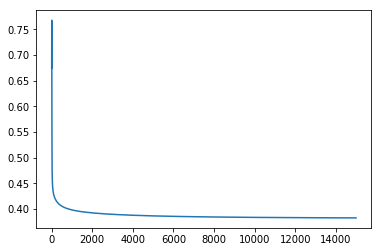

In [49]:
print(J_hist[-1])
plt.plot(J_hist);

**Predicting and scoring**

In [50]:
def predict(X, theta):
    pred = (sigmoid(X@theta) >= 0.5)
    return pred.astype(int)

In [51]:
def score(pred, truth):
    return (pred == truth).mean()

In [52]:
print(f"Train accuracy = {score(predict(X_train, theta_opt), y_train)}")

predictions = predict(X_val, theta_opt)
print(f"Val accuracy = {score(predictions, y_val)}")

Train accuracy = 0.8497191011235955
Val accuracy = 0.8268156424581006


**Plotting learning curve to choose the learning rate alpha**

In [53]:
def learning_curve(alpha_min, alpha_max, step):
    train_errors = []
    val_errors = []
    alpha_range = np.arange(alpha_min, alpha_max, step)
    for alpha in alpha_range:
        theta_opt, _ = grad_descent(X_train, y_train, theta, alpha=alpha, n_iter=10000)
        train_errors.append(1-score(
            predict(X_train, theta_opt), 
            y_train
            ))
        val_errors.append(1-score(
            predict(X_val, theta_opt), 
            y_val
            ))
    fig = plt.figure(figsize=(10,6))
    plt.plot(alpha_range, train_errors, label='Train error')
    plt.plot(alpha_range, val_errors, label='Val error')
    plt.legend()

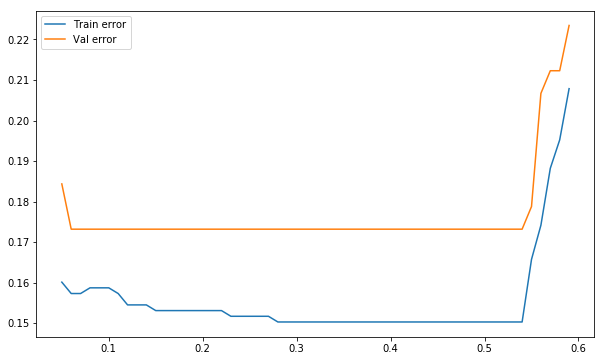

In [54]:
learning_curve(0.05, 0.6, 0.01)

**Formatting `X, y` (the whole training set) and `X_test` (the test set).**  

In [55]:
X = X.values
X = np.c_[np.ones((X.shape[0])), X]
y = y.values
y = y.reshape(-1,1)

In [56]:
theta_final, _ = grad_descent(X, y, theta, alpha=0.35, n_iter=25000)

In [57]:
X_test = X_test.values
X_test = np.c_[np.ones((X_test.shape[0])), X_test]

In [58]:
predict(X_test, theta_final).shape

(418, 1)

**Generating predictions**

In [59]:
def write_pred():
    name = input("Filename? > ")
    raw = pd.read_csv("test.csv")
    predictions = pd.concat([
        raw["PassengerId"].astype('int'), 
        pd.Series(predict(X_test, theta_final).ravel(), name="Survived")
        ], axis=1)
    predictions.to_csv(f"{name}.csv", index=False)

In [60]:
write_pred()

Filename? > logreg_pred


***Scores `0.79904` on Kaggle***

## b/ Logistic Regression with sk-learn

In [61]:
from sklearn.linear_model import LogisticRegression

In [92]:
lr = LogisticRegression(fit_intercept=False, solver='liblinear', C=1, max_iter=1000)
lr.fit(X_train, y_train.ravel()) # need to flatten y which was a column vector

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [93]:
def print_score(m):
    print(f"Train score: {m.score(X_train, y_train)}")
    print(f"Val score: {m.score(X_val, y_val)}")

print_score(lr)

Train score: 0.8398876404494382
Val score: 0.8212290502793296


**Grid search**

In [94]:
from sklearn.model_selection import GridSearchCV
def do_gs(maxiter):    
    lr = LogisticRegression(fit_intercept=False, max_iter=maxiter) #intercepts already added
    param_grid = { 
        "C": [0.01, 0.1, 1, 10, 100, 1000, 10000],
        "solver": ['liblinear', 'lbfgs'],
        "class_weight": [None, {0:3, 1:1}]
        }
    gs = GridSearchCV(estimator=lr,
                      param_grid=param_grid, 
                      scoring='f1',
                      cv=4,
                      n_jobs=-1,
                      iid=False
                     )
    gs = gs.fit(X, y.ravel())
    print(gs.best_score_)
    print(gs.best_params_)
    print(gs.best_estimator_)
    print_score(gs.best_estimator_)

In [95]:
do_gs(5000)

0.7660134129183578
{'C': 1, 'class_weight': None, 'solver': 'liblinear'}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
Train score: 0.8356741573033708
Val score: 0.8324022346368715


**Generating predictions**

In [96]:
best_lr = LogisticRegression(
    **{'C': 1, 'class_weight': None, 'solver': 'liblinear'},
    max_iter=50000,
    fit_intercept=False
    )
best_lr.fit(X, y.ravel())

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=50000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [103]:
def write_pred():
    name = input("Filename? > ")
    raw = pd.read_csv("test.csv")
    predictions = pd.concat([
        raw["PassengerId"].astype('int'), 
        pd.Series(best_lr.predict(X_test).astype('int'), name="Survived")
        ], axis=1)
    predictions.to_csv(f"{name}.csv", index=False)

In [104]:
write_pred()

Filename? > log_reg_sklearn


***Scores `0.79425` on Kaggle*** ~ slightly less but very similar to previous score